### Reminder!

After pulling down the tutorial notebook, immediately make a copy. Then do not modify the original. Do your work in the copy. This will prevent the possibility of git conflicts should the version-controlled file change at any point in the future. (The same exhortation applies to homeworks.)

# Week 8 Tutorial

## Gaussian Process Regression

In this example, we return to the "straight line" problem, generate some mock data, and investigate a "model-free model", a Gaussian Process, for them. The idea is to find a flexible model that can _interpolate_ between the data we have, in order to predict future data lying in the gaps, or beyond the observed domain.

### Requirements

You will need to `pip install scikit-learn` and check that you have v0.18 or higher as a result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['savefig.dpi'] = 200

class SolutionMissingError(Exception):
    def __init__(self):
        Exception.__init__(self,"You need to complete the solution for this code to work!")
def REPLACE_WITH_YOUR_SOLUTION():
    raise SolutionMissingError

## The Data

Let's generate a simple Cepheids-like dataset: observations of $y$ with reported uncertainties $\sigma_y$, at given $x$ values.

In [2]:
import numpy as np
import pylab as plt

xlimits = [0,350]
ylimits = [0,250]

def generate_data(seed=None):
    """
    Generate a 30-point data set, with x and sigma_y as standard, but with
    y values given by

    y = a_0 + a_1 * x + a_2 * x**2 + a_3 * x**3 + noise
    """
    Ndata = 30

    xbar = 0.5*(xlimits[0] + xlimits[1])
    xstd = 0.25*(xlimits[1] - xlimits[0])

    if seed is not None:
        np.random.seed(seed=seed)

    x = xbar + xstd * np.random.randn(Ndata)

    meanerr = 0.025*(xlimits[1] - xlimits[0])

    sigmay = meanerr + 0.3 * meanerr * np.abs(np.random.randn(Ndata))

    a = np.array([37.2,0.93,-0.002,0.0])
    y = a[0] + a[1] * x + a[2] * x**2 + a[3] * x**3 + sigmay*np.random.randn(len(x))

    return x,y,sigmay

def plot_yerr(x, y, sigmay):
    """
    Plot an (x,y,sigma) dataset as a set of points with error bars 
    """
    plt.errorbar(x, y, yerr=sigmay, fmt='.', ms=7, lw=1, color='k')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$y$', fontsize=16)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    return

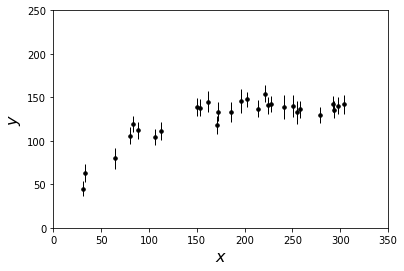

In [3]:
(x, y, sigmay) = generate_data(seed=13)

plot_yerr(x, y, sigmay)

## Fitting a Gaussian Process

Let's follow [Jake VanderPlas' example](http://www.astroml.org/book_figures/chapter8/fig_gp_example.html#book-fig-chapter8-fig-gp-example), to see how to work with the [`scikit-learn` v0.18](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#gaussian-processes-regression-basic-introductory-example) Gaussian Process regression model.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential

### Defining a GP

First we define a kernel function, for populating the covariance matrix of our GP. To avoid confusion, a Gaussian kernel is referred to as a "squared exponential" (or a "radial basis function", RBF). The squared exponential kernel has one hyper-parameter, the length scale that is the Gaussian width.

In [5]:
h = 10.0

kernel = SquaredExponential(length_scale=h, length_scale_bounds=(0.01, 1000.0))
gp0 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

Now, let's draw some samples from the unconstrained process, or equivalently, the prior. Each sample is a function $y(x)$, which we evaluate on a grid. We'll need to assert a value for the kernel hyperparameter $h$, which dictates the correlation length between the datapoints. That will allow us to compute a mean function (which for simplicity we'll set to the mean observed $y$ value), and a covariance matrix that captures the correlations between datapoints. 

In [6]:
np.random.seed(1)
xgrid = np.atleast_2d(np.linspace(0, 399, 100)).T
print("y(x) will be predicted on a grid of length", len(xgrid))

# Draw three sample y(x) functions:
draws = gp0.sample_y(xgrid, n_samples=3)

print("Drew 3 samples, stored in an array with shape ", draws.shape)

y(x) will be predicted on a grid of length 100
Drew 3 samples, stored in an array with shape  (100, 3)


Let's plot these, to see what our prior looks like.

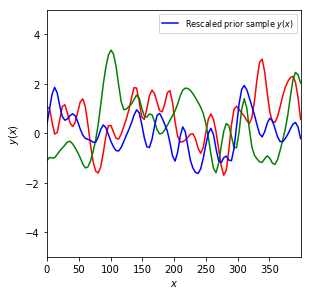

In [7]:
# Start a 4-panel figure:
fig = plt.figure(figsize=(10,10))

# Plot our three prior draws:
ax = fig.add_subplot(221)
ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Rescaled prior sample $y(x)$')
ax.set_xlim(0, 399)
ax.set_ylim(-5, 5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y(x)$')
ax.legend(fontsize=8);

Each predicted $y(x)$ is drawn from a Gaussian of unit variance, and with off-diagonal elements determined by the covariance function. 

Try changing `h` to see what happens to the smoothness of the predictions. 

> Go back up to the cell where `h` is assigned, and re-run that cell and the subsequent ones.

For our data to be well interpolated by this Gaussian Process, it will need to be rescaled such that it has zero mean and unit variance. There are [standard methods for doing this](http://scikit-learn.org/stable/modules/preprocessing.html), but we'll do this rescaling here for transparency - and so we know what to add back in later!

In [8]:
class Rescale():
    def __init__(self, y, err):
        self.original_data = y
        self.original_err = err
        self.mean = np.mean(y)
        self.std = np.std(y)
        self.transform()
        return
    def transform(self):
        self.y = (self.original_data - self.mean) / self.std
        self.err = self.original_err / self.std
        return()
    def invert(self, scaled_y, scaled_err):
        return (scaled_y * self.std + self.mean, scaled_err * self.std)        

In [9]:
rescaled = Rescale(y, sigmay)
print('Mean, variance of original data: ',np.round(np.mean(y)), np.round(np.var(y)))
print('Mean, variance of rescaled data: ',np.round(np.mean(rescaled.y)), np.round(np.var(rescaled.y)))

Mean, variance of original data:  126.0 618.0
Mean, variance of rescaled data:  0.0 1.0


Check that we can undo the scaling, for any `y` and `sigmay`: 

In [10]:
y2, sigmay2 = rescaled.invert(rescaled.y, rescaled.err)
print('Mean, variance of inverted, rescaled data: ',np.round(np.mean(y2)), np.round(np.var(y2)))
print('Maximum differences in y, sigmay, after round trip: ',np.max(np.abs(y2 - y)), np.max(np.abs(sigmay2 - sigmay)))

Mean, variance of inverted, rescaled data:  126.0 618.0
Maximum differences in y, sigmay, after round trip:  0.0 1.7763568394002505e-15


### Constraining the GP

Now, using the same covariance function, lets "fit" the GP by constraining each draw from the GP to go through our data points, and _optimizing_ the length scale hyperparameter `h`. 

Let's first look at how this would work for two data points with no uncertainty. 

In [11]:
# Choose two of our (rescaled) datapoints:
x1 = np.array([x[10], x[12]])
rescaled_y1 = np.array([rescaled.y[10], rescaled.y[12]])
rescaled_sigmay1 = np.array([rescaled.err[10], rescaled.err[12]])

# Instantiate a GP model, with initial length_scale h=10:
kernel = SquaredExponential(length_scale=10.0, length_scale_bounds=(0.01, 1000.0))
gp1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit it to our two noiseless datapoints:
gp1.fit(x1[:, None], rescaled_y1)

# We have fit for the length scale parameter: print the result here:
params = gp1.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid1, rescaled_ygrid1_err = gp1.predict(xgrid, return_std=True)

# And undo scaling, of both y(x) on our grid, and our two constraining data points:
ygrid1, ygrid1_err = rescaled.invert(rescaled_ygrid1, rescaled_ygrid1_err)
y1, sigmay1 = rescaled.invert(rescaled_y1, rescaled_sigmay1)

Best-fit kernel length scale = 10.000000000000002 cf. input 10.0


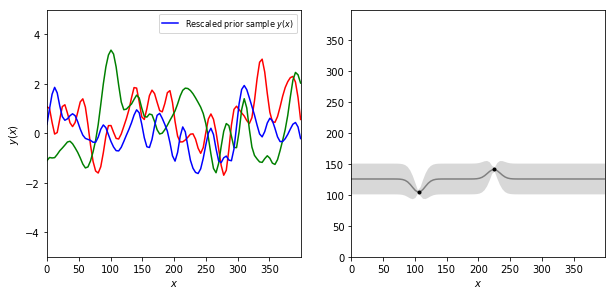

In [12]:
ax = fig.add_subplot(222)
ax.plot(xgrid, ygrid1, '-', color='gray', label='Posterior mean $y(x)$')
ax.fill(np.concatenate([xgrid, xgrid[::-1]]),
        np.concatenate([(ygrid1 - ygrid1_err), (ygrid1 + ygrid1_err)[::-1]]),
        alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
ax.plot(x1, y1, '.k', ms=6, label='Noiseless constraints')
ax.set_xlim(0, 399)
ax.set_ylim(0, 399)
ax.set_xlabel('$x$')
fig

In the absence of information, the GP tends to produce $y(x)$ that fluctuate around the prior mean function, which we chose to be a constant. Let's draw some samples from the posterior PDF, and overlay them.

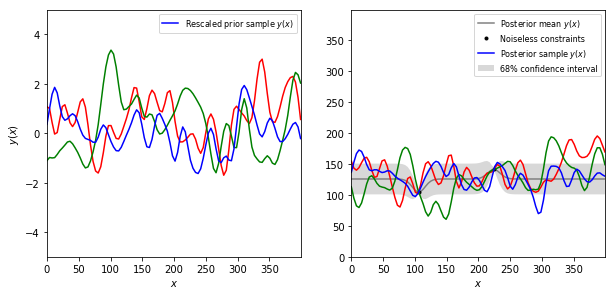

In [13]:
draws = gp1.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Posterior sample $y(x)$')
ax.legend(fontsize=8)
fig

See how the posterior sample $y(x)$ functions all pass through the constrained points.

### Including Observational Uncertainties

The mechanism for including uncertainties is a little esoteric: `scikit-learn` wants to be given a "nugget," called `alpha`, to multiply the diagonal elements of the covariance matrix.

In [14]:
# Choose two of our datapoints:
x2 = np.array([x[10], x[12]])
rescaled_y2 = np.array([rescaled.y[10], rescaled.y[12]])
rescaled_sigmay2 = np.array([rescaled.err[10], rescaled.err[12]])

# Instantiate a GP model, including observational errors:
kernel = SquaredExponential(length_scale=10.0, length_scale_bounds=(0.01, 1000.0))
gp2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, 
                               alpha=(rescaled_sigmay2 / rescaled_y2) ** 2,
                               random_state=0)

# Fit it to our two noisy datapoints:
gp2.fit(x2[:, None], rescaled_y2)

# We have fit for the length scale parameter: print the result here:
params = gp2.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid2, rescaled_ygrid2_err = gp2.predict(xgrid, return_std=True)

# And undo scaling:
ygrid2, ygrid2_err = rescaled.invert(rescaled_ygrid2, rescaled_ygrid2_err)
y2, sigmay2 = rescaled.invert(rescaled_y2, rescaled_sigmay2)

# Draw three posterior sample y(x):
draws = gp2.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

Best-fit kernel length scale = 10.000000000000002 cf. input 10.0


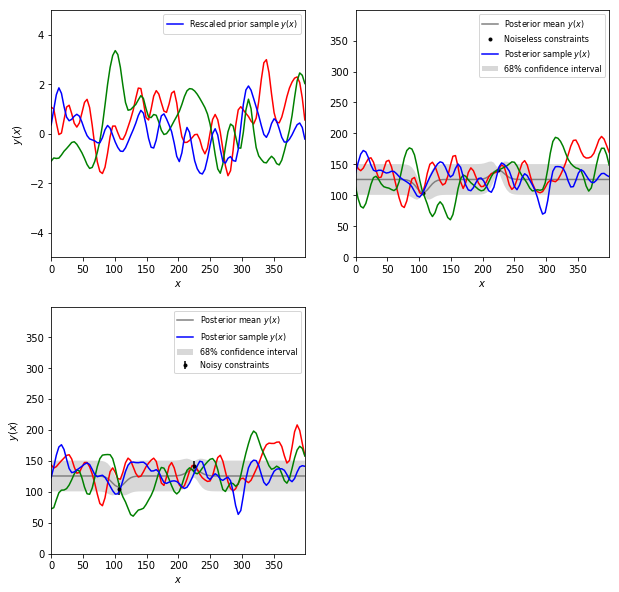

In [15]:
ax = fig.add_subplot(223)

def gp_plot(ax, xx, yy, ee, datax, datay, datae, samples, legend=True):
    ax.cla()
    ax.plot(xx, yy, '-', color='gray', label='Posterior mean $y(x)$')
    ax.fill(np.concatenate([xx, xx[::-1]]),
            np.concatenate([(yy - ee), (yy + ee)[::-1]]),
            alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
    ax.errorbar(datax, datay, datae, fmt='.k', ms=6, label='Noisy constraints')
    ax.set_xlim(0, 399)
    ax.set_ylim(0, 399)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y(x)$')
    ax.plot(xgrid, samples[:,0], '-r')
    ax.plot(xgrid, samples[:,1], '-g')
    ax.plot(xgrid, samples[:,2], '-b', label='Posterior sample $y(x)$')
    if legend: ax.legend(fontsize=8)
    return

gp_plot(ax, xgrid, ygrid2, ygrid2_err, x2, y2, sigmay2, draws, legend=True)
fig

Now, the posterior sample $y(x)$ functions pass through the constraints _within the errors_.

### Using all the Data

Now let's extend the above example to use all of our datapoints. This additional information should pull the predictions further away from the initial mean function.

In [16]:
# Use all of our datapoints:
x3 = x
rescaled_y3 = rescaled.y
rescaled_sigmay3 = rescaled.err

# Instantiate a GP model, including observational errors:
kernel = SquaredExponential(length_scale=10.0, length_scale_bounds=(0.01, 1000.0))
gp3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, 
                               alpha=(rescaled_sigmay3 / rescaled_y3) ** 2,
                               random_state=0)

# Fit it to our noisy datapoints:
gp3.fit(x3[:, None], rescaled_y3)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid3, rescaled_ygrid3_err = gp3.predict(xgrid, return_std=True)

# And undo scaling:
ygrid3, ygrid3_err = rescaled.invert(rescaled_ygrid3, rescaled_ygrid3_err)
y3, sigmay3 = rescaled.invert(rescaled_y3, rescaled_sigmay3)

# We have fitted the length scale parameter - print the result here:
params = gp3.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',10.0)

# Draw three posterior sample y(x):
draws = gp3.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

Best-fit kernel length scale = 62.61050679713862 cf. input 10.0


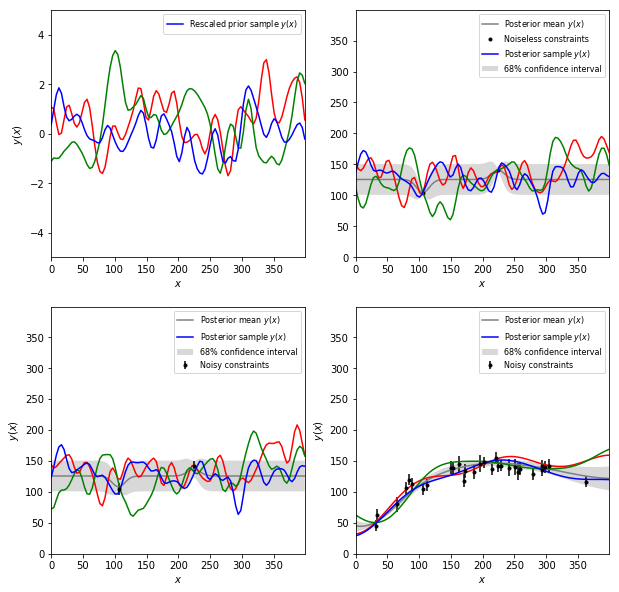

In [17]:
ax = fig.add_subplot(224)

gp_plot(ax, xgrid, ygrid3, ygrid3_err, x3, y3, sigmay3, draws, legend=True)
fig

# fig.savefig('../../lessons/graphics/mfm_gp_example_pjm.png')

We now see the Gaussian Process model providing a smooth interpolation between the points. The posterior samples show fluctuations, but all are plausible under our assumptions.

## Exercises

1. Extend the analysis above to do a _posterior predictive model check_ of your GP inference. You'll need to generate new replica datasets from posterior draws from the fitted GP. Use the discrepancy measure $T(\theta,d) = -2 \log L(\theta;d)$. Does your GP provide an adequate fit to the data? Could it be over-fitting? What could you do to prevent this? There's some starter code for you below.

----

2. The `scikit-learn` implementation of Gaussian Processes provides a `fit` method that finds the best fit (maximum likelihood) value of the hyper-parameters. Alternatively, it can simply return the log marginal likelihood for a given choice of hyper-parameters. Try using this feature to characterize the posterior PDF for `h` via a grid search. How sharply is it peaked? Could you use the peak value of the log marginal likelihood to approximate the Evidence and compare kernels that way?

----

3. Try a different kernel function, from the list given in the [scikit-learn docs here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process). "Matern" could be a good choice - note that it has an additional hyperparameter, `nu`, that controls the smoothness of the interpolant functions. 



In [18]:
def generate_replica_data(xgrid, ygrid, seed=None):
    """
    Generate a 30-point data set, with x and sigma_y as standard, but with
    y values given by the "lookup tables" (gridded function) provided.
    """
    Ndata = 30

    xbar = 0.5*(xlimits[0] + xlimits[1])
    xstd = 0.25*(xlimits[1] - xlimits[0])

    if seed is not None:
        np.random.seed(seed=seed)

    x = xbar + xstd * np.random.randn(Ndata)

    meanerr = 0.025*(xlimits[1] - xlimits[0])

    sigmay = meanerr + 0.3 * meanerr * np.abs(np.random.randn(Ndata))

    # Look up value given input lookup table
    y = REPLACE_WITH_YOUR_SOLUTION() 
    y += sigmay*np.random.randn(len(x))

    return x,y,sigmay


In [19]:
def discrepancy(ygrid, yy, ss):
    """
    Compute discrepancy measure comparing model y (on a grid) and 
    observed/replica yy (with its uncertainty ss). 
    
    T = -2 log L = ...
    """
    T = REPLACE_WITH_YOUR_SOLUTION()
    return T

In [20]:
# Draw N posterior sample y(x)'s and accumulate test statistics:
N = 1000
T = np.zeros(N)
draws = gp3.sample_y(xgrid, n_samples=N)
for k in range(N):
    ygrid, dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))
    xx, yy, ss = generate_replica_data(xgrid, ygrid)
    T[k] = discrepancy(ygrid, yy, ss)
    
# Plot P(T(y_rep,theta)-T(y,theta)|y)

SolutionMissingError: You need to complete the solution for this code to work!